In [ ]:
!pip install noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp312-cp312-linux_x86_64.whl size=56632 sha256=40ec79c1670a4bfef034d6c15d5b70e192ec63b10ebbdf8f02f2a5a624fae3fc
  Stored in directory: /root/.cache/pip/wheels/78/71/a2/47a0c6acdeb8f7a2f4e69067d3c737219e36414136441a1ef8
Successfully built noise


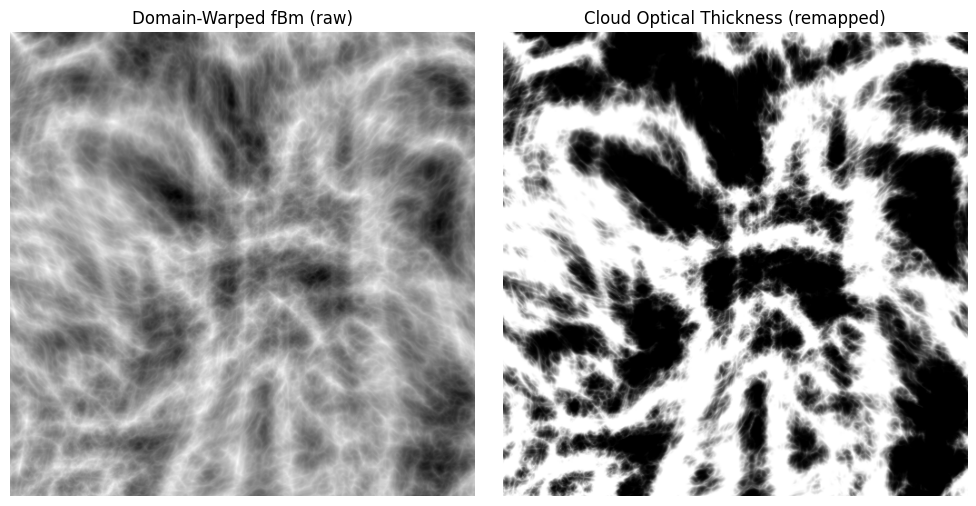

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2  # pip install noise

# ----------------------------
# Scalar Perlin + fBm variants
# ----------------------------
def perlin_scalar(x, y, repeat=1024, base=0):
    # pnoise2 requires scalars; returns roughly [-1,1]
    return pnoise2(float(x), float(y), repeatx=repeat, repeaty=repeat, base=base)

def fbm_billow_scalar(x, y, octaves=5, lacunarity=2.0, gain=0.5, base_freq=1.0, base=0):
    amp, freq, v = 1.0, base_freq, 0.0
    for _ in range(octaves):
        v += amp * abs(perlin_scalar(x*freq, y*freq, base=base))
        freq *= lacunarity
        amp *= gain
    return v  # >= 0

def fbm_ridged_scalar(x, y, octaves=5, lacunarity=2.0, gain=0.5, base_freq=1.0, base=0):
    amp, freq, v = 1.0, base_freq, 0.0
    for _ in range(octaves):
        n = 1.0 - abs(perlin_scalar(x*freq, y*freq, base=base))  # [0,1]
        v += amp * (n*n)
        freq *= lacunarity
        amp *= gain
    return v

def domain_warp_scalar(x, y, warp_strength=0.5, warp_freq=0.4, base=17):
    # two low-freq fields to perturb (x,y)
    wx = perlin_scalar(x*warp_freq + 100.0, y*warp_freq + 23.0, base=base)
    wy = perlin_scalar(x*warp_freq - 37.0, y*warp_freq - 81.0, base=base)
    return x + warp_strength*wx, y + warp_strength*wy

# ----------------------------
# Remapping helpers
# ----------------------------
def normalize01(img):
    m, M = float(img.min()), float(img.max())
    if M == m:
        return np.zeros_like(img, dtype=np.float32)
    return (img - m) / (M - m)

def smoothstep(edge0, edge1, x):
    t = np.clip((x - edge0) / (edge1 - edge0), 0.0, 1.0)
    return t*t*(3 - 2*t)

def remap_cloud(field, density=0.55, softness=0.18, thickness=1.6):
    # feathered threshold + core emphasis
    m = smoothstep(density - softness, density + softness, field)
    return np.power(m, thickness)

# ----------------------------
# Main: build a cloud field
# ----------------------------
def make_cloud(res=512,
               world_scale=5.0,       # larger => larger features
               use_ridged=True,       # True=cumulus-y; False=billow puffs
               base_octaves=5,
               base_lac=2.05,
               base_gain=0.55,
               warp_strength=0.75,
               warp_freq=0.35,
               seed=1337,
               density=0.55,
               softness=0.18,
               thickness=1.6):
    out = np.zeros((res, res), dtype=np.float32)

    # choose sampler
    sampler = fbm_ridged_scalar if use_ridged else fbm_billow_scalar

    # sample per-pixel (scalar-safe for pnoise2)
    for i in range(res):
        for j in range(res):
            # normalized coords in "world" units
            x = (i / res) * world_scale
            y = (j / res) * world_scale

            # warp them
            wx, wy = domain_warp_scalar(x, y,
                                        warp_strength=warp_strength,
                                        warp_freq=warp_freq,
                                        base=seed+1)

            # fBm sample
            out[i, j] = sampler(wx, wy,
                                octaves=base_octaves,
                                lacunarity=base_lac,
                                gain=base_gain,
                                base_freq=1.0,
                                base=seed)

    raw = normalize01(out)
    clouds = remap_cloud(raw, density=density, softness=softness, thickness=thickness)
    return raw, clouds

if __name__ == "__main__":
    # --- tweak these ---
    res = 512
    world_scale = 5.0
    use_ridged = True       # try False for softer, billowy sheets
    base_octaves = 5
    base_lac = 2.05
    base_gain = 0.55
    warp_strength = 0.75
    warp_freq = 0.35
    seed = 1337
    density = 0.55
    softness = 0.18
    thickness = 1.6

    raw, clouds = make_cloud(
        res=res,
        world_scale=world_scale,
        use_ridged=use_ridged,
        base_octaves=base_octaves,
        base_lac=base_lac,
        base_gain=base_gain,
        warp_strength=warp_strength,
        warp_freq=warp_freq,
        seed=seed,
        density=density,
        softness=softness,
        thickness=thickness
    )

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(raw, cmap="gray")
    plt.title("Domain-Warped fBm (raw)")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(clouds, cmap="gray")
    plt.title("Cloud Optical Thickness (remapped)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


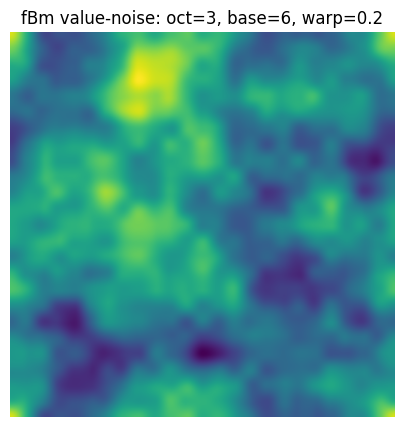

In [ ]:
# Generate a clearly "cloud-like" 2D noise field using multi-octave **value noise** (not pnoise2),
# then combine into fBm and save/show it so you can judge quickly.
#
# This avoids dependency issues and the "flat gradient" problem you saw by explicitly
# building smooth, tile-wrapped value noise and summing a few octaves (2–3).
#
# You can tweak WIDTH/HEIGHT, OCTAVES, BASE_FREQ, PERSISTENCE, and optional WARP_STRENGTH.
# No external libraries needed beyond numpy/matplotlib.

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

WIDTH, HEIGHT = 512, 512

def smoothstep(t):
    return t * t * (3.0 - 2.0 * t)

def value_noise_2d(width, height, grid, seed=None):
    """
    Tile-wrapped 2D value noise sampled at (width x height) from a (grid x grid) random lattice.
    Uses smooth (cubic) interpolation for cloud-like blobs.
    """
    if seed is not None:
        local_rng = np.random.default_rng(seed)
    else:
        local_rng = rng

    # Random lattice of size (grid+1)x(grid+1) so we can index x+1/y+1 safely; wrap with modulo.
    lattice = local_rng.random((grid + 1, grid + 1))

    # Continuous lattice-space coords for each pixel
    # Note: we cover exactly `grid` cells across the image (tileable if desired).
    xs = np.linspace(0.0, grid, width, endpoint=False)
    ys = np.linspace(0.0, grid, height, endpoint=False)
    X, Y = np.meshgrid(xs, ys, indexing="xy")

    x0 = np.floor(X).astype(int)
    y0 = np.floor(Y).astype(int)
    x1 = (x0 + 1) % grid
    y1 = (y0 + 1) % grid

    # Fractions inside each cell
    fx = X - x0
    fy = Y - y0

    # Smooth interpolation weights
    sx = smoothstep(fx)
    sy = smoothstep(fy)

    # Corner values (row-major: [y, x])
    v00 = lattice[y0, x0]
    v10 = lattice[y0, x1]
    v01 = lattice[y1, x0]
    v11 = lattice[y1, x1]

    # Bilinear with smooth weights
    nx0 = v00 * (1 - sx) + v10 * sx
    nx1 = v01 * (1 - sx) + v11 * sx
    val = nx0 * (1 - sy) + nx1 * sy
    return val  # already in [0,1]

def fbm_value(width, height, octaves=3, base_freq=6, persistence=0.5, seed=1234,
              warp_strength=0.0):
    """
    fBm built from value noise octaves. base_freq is number of base grid cells across the image.
    persistence controls how much each octave contributes (0.5 is a good start).
    Optional domain warp: displace coordinates by a very low-frequency field for more "cloud" feel.
    """
    rng_local = np.random.default_rng(seed)

    # Optional domain warp fields (very low frequency so they bend blobs gently).
    if warp_strength > 0.0:
        warp_grid = max(2, base_freq // 2)  # very low-frequency warp
        warp_x = value_noise_2d(width, height, warp_grid, seed=rng_local.integers(1<<30))
        warp_y = value_noise_2d(width, height, warp_grid, seed=rng_local.integers(1<<30))
        # Center to [-0.5, 0.5] and scale
        warp_x = (warp_x - 0.5) * 2.0 * warp_strength
        warp_y = (warp_y - 0.5) * 2.0 * warp_strength
    else:
        warp_x = warp_y = None

    # Precompute base coord grids (normalized 0..1)
    u = np.linspace(0.0, 1.0, width, endpoint=False)
    v = np.linspace(0.0, 1.0, height, endpoint=False)
    U, V = np.meshgrid(u, v, indexing="xy")

    result = np.zeros((height, width), dtype=np.float32)
    amp_sum = 0.0
    amp = 1.0
    freq = base_freq

    for _ in range(octaves):
        # Sample octave at grid resolution `freq`
        if warp_x is not None:
            # Simple domain warp: offset UVs before sampling
            # Wrap UVs to [0,1)
            UU = np.mod(U + warp_x, 1.0)
            VV = np.mod(V + warp_y, 1.0)
            # Map to lattice coordinates
            noise = value_noise_2d(width, height, freq, seed=rng_local.integers(1<<30))
        else:
            noise = value_noise_2d(width, height, freq, seed=rng_local.integers(1<<30))

        result += amp * noise
        amp_sum += amp
        amp *= persistence
        freq = int(freq * 2)  # lacunarity ~ 2

    result /= amp_sum
    # Normalize to [0,1] robustly
    mn, mx = float(result.min()), float(result.max())
    if mx > mn:
        result = (result - mn) / (mx - mn)
    else:
        result[:] = 0.5

    return result

# --- Generate fields ---
OCTAVES = 3
BASE_FREQ = 6        # 6 cells across the image (large puffs). Try 4..12.
PERSISTENCE = 0.5    # Each octave is half as strong as the previous
WARP_STRENGTH = 0.2  # 0.0 for pure fBm; 0.1–0.3 adds gentle bending

fbm_field = fbm_value(WIDTH, HEIGHT,
                      octaves=OCTAVES,
                      base_freq=BASE_FREQ,
                      persistence=PERSISTENCE,
                      warp_strength=WARP_STRENGTH)

# Show a preview (single plot, no custom colors/styles, per tool requirements)
plt.figure(figsize=(5,5))
plt.imshow(fbm_field)
plt.title(f"fBm value-noise: oct={OCTAVES}, base={BASE_FREQ}, warp={WARP_STRENGTH}")
plt.axis("off")
plt.show()


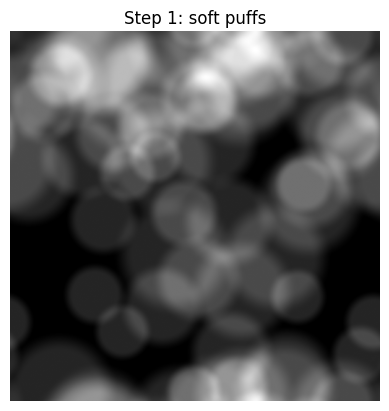

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def soft_disks(res=512, n_blobs=60,
               r_min=0.05, r_max=0.12,   # blob radius range in UV units
               edge=0.5,                 # rim softness: 0=hard, 1=very soft
               mode="max",               # "max" = union of puffs, "sum" = additive density
               tile=True,                # make it seamlessly tile on both axes
               seed=1337):
    rng = np.random.default_rng(seed)
    # UV grid in [0,1)
    y, x = np.mgrid[0:res, 0:res].astype(np.float32) / res
    field = np.zeros((res, res), np.float32)

    for _ in range(n_blobs):
        cx, cy = rng.random(2)
        r = rng.uniform(r_min, r_max)

        # torus (wrap-around) distance for seamless tiling
        dx = np.abs(x - cx);  dx = np.minimum(dx, 1.0 - dx) if tile else dx
        dy = np.abs(y - cy);  dy = np.minimum(dy, 1.0 - dy) if tile else dy
        d = np.hypot(dx, dy) / r  # normalized radial distance

        # soft disk: 1 at center, ~0 outside radius*(1+edge)
        # m in [0,1], smooth rim via smoothstep-like curve
        t = np.clip((d - 1.0) / max(1e-6, edge), 0.0, 1.0)
        m = 1.0 - (t*t*(3 - 2*t))

        if mode == "sum":
            field += m
        else:  # "max"
            field = np.maximum(field, m)

    # normalize
    if mode == "sum":
        m = field.max()
        if m > 0: field /= m
    return np.clip(field, 0, 1)

if __name__ == "__main__":
    tex = soft_disks(res=512, n_blobs=55, r_min=0.05, r_max=0.11, edge=0.55,
                     mode="sum", tile=True, seed=1337)
    plt.imshow(tex, cmap="gray"); plt.axis("off"); plt.title("Step 1: soft puffs")
    plt.show()


In [ ]:
# Demo: enforce ERA5 coverage fractions locally using a per‑tile threshold field.
# This shows exactly how the procedural "look" map (fbm) combines with a coverage map
# so that, within each neighborhood, the fraction of cloudy pixels matches the ERA5
# mean coverage — while shapes remain cloud‑like.
#
# Output preview figures + write resulting mask/threshold as PNGs for inspection.

import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from scipy.ndimage import gaussian_filter

# 1) Create a synthetic "ERA5 coverage" field C in [0,1] with broad structure.
H, W = 512, 512
yy, xx = np.mgrid[0:H, 0:W]
C = np.array(Image.open('/content/red_only.png'))
C = np.clip((C - C.min())/(C.max()-C.min()), 0, 1)
C = gaussian_filter(C, sigma=10)  # "blurred ERA5" look

L = fbm_field  # rename to L for "look" ∈ [0,1]

# 3) Compute a per‑tile threshold τ so that, in each tile, mean( L > τ ) ≈ mean(C).
def per_tile_threshold(L, C, tile=32, iters=10):
    H, W = L.shape
    Th = np.zeros((H//tile, W//tile), dtype=np.float32)
    for ty in range(0, H, tile):
        for tx in range(0, W, tile):
            Lyx = L[ty:ty+tile, tx:tx+tile]
            Cyx = C[ty:ty+tile, tx:tx+tile]
            desired = float(Cyx.mean())  # target cloudy fraction in this tile
            # Binary search on threshold in [0,1]
            lo, hi = 0.0, 1.0
            t = 0.5
            for _ in range(iters):
                frac = float((Lyx > t).mean())
                if frac > desired:
                    lo = t
                else:
                    hi = t
                t = 0.5*(lo+hi)
            Th[ty//tile, tx//tile] = t
    # Upsample τ back to full resolution (nearest-neighbor then blur for smoothness)
    Th_full = np.repeat(np.repeat(Th, tile, axis=0), tile, axis=1)
    Th_full = Th_full[:H, :W]
    Th_full = gaussian_filter(Th_full, sigma=tile*0.4)  # soften seams
    return Th_full

T = per_tile_threshold(L, C, tile=32, iters=12)

# 4) Build the cloudy mask and an opacity suggestion.
Mask = (L > T).astype(np.float32)
Opacity = Mask * C  # simplest modulation; can also scale by C^gamma

# 5) Quick sanity checks: do we match coverage locally?
def tile_stats(M, C, tile=32):
    diffs = []
    for ty in range(0, H, tile):
        for tx in range(0, W, tile):
            m = float(M[ty:ty+tile, tx:tx+tile].mean())
            c = float(C[ty:ty+tile, tx:tx+tile].mean())
            diffs.append(m - c)
    diffs = np.array(diffs)
    return diffs.mean(), np.abs(diffs).mean(), diffs.max(), diffs.min()

mean_diff, mad_abs, mx, mn = tile_stats(Mask, C, tile=32)

# 7) Visualize
plt.figure(figsize=(10,9))

plt.subplot(2,3,1); plt.imshow(C, vmin=0, vmax=1); plt.title("ERA5-like coverage C"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(L, vmin=0, vmax=1); plt.title("Procedural 'look' L"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(T, vmin=0, vmax=1); plt.title("Per-tile threshold τ"); plt.axis("off")
plt.subplot(2,3,4); plt.imshow(Mask, vmin=0, vmax=1); plt.title("Mask: 1[L>τ]"); plt.axis("off")
plt.subplot(2,3,5); plt.imshow(Opacity, vmin=0, vmax=1); plt.title("Opacity = Mask·C"); plt.axis("off")
plt.subplot(2,3,6);
plt.text(0.05, 0.7, f"Local coverage match (tile=32):\n"
                   f"mean(M-C) = {mean_diff:.4f}\n"
                   f"mean |M-C| = {mad_abs:.4f}\n"
                   f"max diff   = {mx:.4f}\n"
                   f"min diff   = {mn:.4f}", fontsize=12)
plt.axis("off")

plt.tight_layout()
plt.show()


ValueError: operands could not be broadcast together with shapes (512,512) (721,1440,4) 

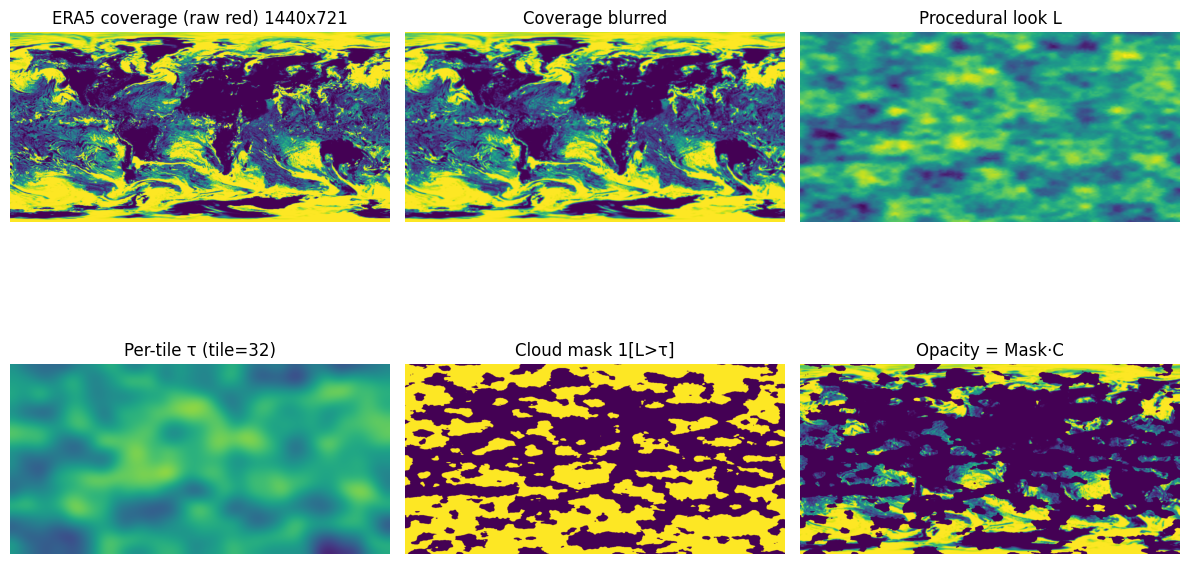

Saved: {'coverage_blurred': './era5_cov_blurred.png', 'look': './look_fbm_world.png', 'threshold_tau': './threshold_tau_world.png', 'cloud_mask': './cloud_mask_world.png', 'opacity': './opacity_world.png'}


In [4]:
# Write a single-file Colab-ready script containing the full pipeline.
"""
ERA5 Cloud Mask Pipeline (Colab-ready, single cell or script)

What it does
------------
Given an ERA5 coverage image where the RED channel encodes cloud cover [0..255],
this builds a visually cloud-like mask that *locally* matches ERA5 area fraction:
1) Load red channel => coverage C in [0,1]
2) Light blur (~1–2 grid cells)
3) Generate procedural "look" field L (multi-octave value-noise fBm)
4) Solve per-tile threshold τ so, in each neighborhood, mean(1[L>τ]) ≈ mean(C)
5) Output: blurred coverage, look, threshold τ, binary cloud mask, opacity=Mask·C

How to use in Colab
-------------------
Option A: Upload your file interactively (red_only.png)
    from google.colab import files
    files.upload()  # pick your ERA5 red-only image
    !python era5_cloud_pipeline.py --input red_only.png

Option B: Run as a cell (no CLI). Set INPUT_PATH below and run the cell.

Outputs (PNG files)
-------------------
- era5_cov_blurred.png
- look_fbm_world.png
- threshold_tau_world.png
- cloud_mask_world.png
- opacity_world.png
"""

import os, math, argparse
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
import imageio.v2 as imageio
import matplotlib.pyplot as plt

# ------------------------------ Parameters ------------------------------
# You can override these via CLI flags or by editing here.
DEFAULTS = dict(
    input_path="red_only.png",  # Your ERA5 red-channel PNG
    blur_sigma=1.2,             # ~1–2 ERA5 cells
    tile_px=32,                 # neighborhood size for local coverage matching
    fbm_octaves=3,
    fbm_base_freq=12,           # number of base grid cells across the width
    fbm_persistence=0.5,
    fbm_seed=2025,
    show_plots=True,
    save_dir="."
)

# ------------------------------ Noise utils ------------------------------
def smoothstep(t):
    return t * t * (3.0 - 2.0 * t)

def value_noise_2d(width, height, grid, seed=None):
    """
    Tile-wrapped 2D value noise sampled at (width x height) from a (grid x grid) random lattice.
    Smooth (cubic) interpolation for cloud-like blobs.
    """
    rng = np.random.default_rng(seed)
    lattice = rng.random((grid + 1, grid + 1))

    xs = np.linspace(0.0, grid, width, endpoint=False)
    ys = np.linspace(0.0, grid, height, endpoint=False)
    X, Y = np.meshgrid(xs, ys, indexing="xy")

    x0 = np.floor(X).astype(int); y0 = np.floor(Y).astype(int)
    x1 = (x0 + 1) % grid;        y1 = (y0 + 1) % grid

    fx = X - x0; fy = Y - y0
    sx = smoothstep(fx); sy = smoothstep(fy)

    v00 = lattice[y0, x0]; v10 = lattice[y0, x1]
    v01 = lattice[y1, x0]; v11 = lattice[y1, x1]

    nx0 = v00 * (1 - sx) + v10 * sx
    nx1 = v01 * (1 - sx) + v11 * sx
    return nx0 * (1 - sy) + nx1 * sy  # [0,1]

def fbm_value(
    width,
    height,
    octaves=3,
    base_freq=12,
    persistence=0.5,
    seed=2025,
    # new multi-scale controls:
    medium_mult=3,        # medium layer frequency = base_freq * medium_mult
    medium_gain=0.35,     # strength of medium detail
    fine_mult=12,         # fine layer frequency = base_freq * fine_mult
    fine_gain=0.12        # strength of fine speckle
):
    """
    fBm with added medium- and fine-frequency layers.
    - Base fBm gives large decks (same behavior as before).
    - Medium adds smaller blobs/wisps at lower amplitude.
    - Fine adds subtle speckle, biased toward edges so decks don't break up.
    """
    rng = np.random.default_rng(seed)

    # --- Base (large decks): standard fBm ---
    base = np.zeros((height, width), dtype=np.float32)
    amp_sum = 0.0; amp = 1.0; freq = base_freq
    for _ in range(octaves):
        base += amp * value_noise_2d(width, height, freq, seed=rng.integers(1<<30))
        amp_sum += amp; amp *= persistence; freq = int(freq * 2)
    base /= max(amp_sum, 1e-6)

    # Normalize base to [0,1]
    bmin, bmax = float(base.min()), float(base.max())
    base = (base - bmin) / (bmax - bmin + 1e-6)

    # --- Edge mask from base (concentrates detail near boundaries) ---
    gy, gx = np.gradient(base)
    edge = np.hypot(gx, gy)
    # Normalize edge and sharpen a bit
    e_min, e_max = float(edge.min()), float(edge.max())
    edge = (edge - e_min) / (e_max - e_min + 1e-6)
    edge = smoothstep(np.clip(edge * 1.5, 0.0, 1.0))  # 0 in flats, 1 near edges

    # --- Medium layer: smaller blobs/wisps ---
    medium = value_noise_2d(width, height, max(2, int(base_freq * medium_mult)),
                            seed=rng.integers(1<<30))
    medium = (medium - 0.5)  # center
    # Blend more on edges, a little in flats
    medium_contrib = medium_gain * (0.6 + 0.4 * edge) * medium

    # --- Fine layer: subtle speckle, mostly on edges so decks don't fragment ---
    fine = value_noise_2d(width, height, max(2, int(base_freq * fine_mult)),
                          seed=rng.integers(1<<30))
    fine = (fine - 0.5)
    fine_contrib = fine_gain * (0.3 + 0.7 * edge) * fine

    # --- Combine and normalize back to [0,1] ---
    L = base + medium_contrib + fine_contrib
    Lmin, Lmax = float(L.min()), float(L.max())
    if Lmax > Lmin:
        L = (L - Lmin) / (Lmax - Lmin)
    else:
        L[:] = 0.5

    # Slight gamma to keep decks coherent but not flat
    L = np.clip(L, 0.0, 1.0) ** 0.9
    return L

# usage stays the same:
# L = fbm_value(W, H, octaves=fbm_octaves, base_freq=fbm_base_freq,
#               persistence=fbm_persistence, seed=fbm_seed)

# ------------------------------ Threshold solver ------------------------------
def per_tile_threshold(L, C, tile=32, iters=12):
    """
    Compute τ field (upsampled) so that, tile-wise, mean(1[L>τ]) ≈ mean(C).
    """
    H, W = L.shape
    tiles_y = math.ceil(H / tile)
    tiles_x = math.ceil(W / tile)
    Th = np.zeros((tiles_y, tiles_x), dtype=np.float32)

    for ty in range(tiles_y):
        for tx in range(tiles_x):
            y0, x0 = ty*tile, tx*tile
            y1, x1 = min(H, y0+tile), min(W, x0+tile)

            Lyx = L[y0:y1, x0:x1]
            Cyx = C[y0:y1, x0:x1]
            desired = float(Cyx.mean())

            # Binary search τ ∈ [0,1]
            lo, hi = 0.0, 1.0; t = 0.5
            for _ in range(iters):
                frac = float((Lyx > t).mean())
                if frac > desired: lo = t
                else: hi = t
                t = 0.5*(lo+hi)
            Th[ty, tx] = t

    # Upsample τ back to full res, soften seams
    Th_full = np.repeat(np.repeat(Th, tile, axis=0), tile, axis=1)
    Th_full = Th_full[:H, :W]
    Th_full = gaussian_filter(Th_full, sigma=tile*0.8)
    return Th_full

def tile_stats(M, C, tile=32):
    H, W = M.shape
    tiles_y = math.ceil(H / tile); tiles_x = math.ceil(W / tile)
    diffs = []
    for ty in range(tiles_y):
        for tx in range(tiles_x):
            y0, x0 = ty*tile, tx*tile
            y1, x1 = min(H, y0+tile), min(W, x0+tile)
            m = float(M[y0:y1, x0:x1].mean())
            c = float(C[y0:y1, x0:x1].mean())
            diffs.append(m - c)
    diffs = np.array(diffs)
    return dict(
        mean_diff=float(diffs.mean()),
        mean_abs_diff=float(np.abs(diffs).mean()),
        max_diff=float(diffs.max()),
        min_diff=float(diffs.min())
    )

# ------------------------------ Core pipeline ------------------------------
def run_pipeline(
    input_path=DEFAULTS["input_path"],
    blur_sigma=DEFAULTS["blur_sigma"],
    tile_px=DEFAULTS["tile_px"],
    fbm_octaves=DEFAULTS["fbm_octaves"],
    fbm_base_freq=DEFAULTS["fbm_base_freq"],
    fbm_persistence=DEFAULTS["fbm_persistence"],
    fbm_seed=DEFAULTS["fbm_seed"],
    show_plots=DEFAULTS["show_plots"],
    save_dir=DEFAULTS["save_dir"]
):
    # 1) Load red channel as coverage in [0,1]
    img = Image.open(input_path).convert("RGB")
    arr = np.asarray(img).astype(np.float32)
    C_raw = arr[..., 0] / 255.0

    # 2) Gentle blur
    C = gaussian_filter(C_raw, sigma=blur_sigma)
    C = np.clip(C, 0.0, 1.0)

    H, W = C.shape

    # 3) Procedural look field at same resolution
    L = fbm_value(W, H, octaves=fbm_octaves, base_freq=fbm_base_freq,
                  persistence=fbm_persistence, seed=fbm_seed)

    # 4) Per-tile threshold τ
    T = per_tile_threshold(L, C, tile=tile_px, iters=12)

    # 5) Cloud mask and opacity
    Mask = (L > T).astype(np.float32)
    Opacity = Mask * C

    # 6) Save
    def save(name, img_arr):
        path = os.path.join(save_dir, name)
        imageio.imwrite(path, (np.clip(img_arr, 0, 1) * 255).astype(np.uint8))
        return path

    paths = dict(
        coverage_blurred = save("era5_cov_blurred.png", C),
        look             = save("look_fbm_world.png", L),
        threshold_tau    = save("threshold_tau_world.png", T),
        cloud_mask       = save("cloud_mask_world.png", Mask),
        opacity          = save("opacity_world.png", Opacity),
    )

    # 7) Diagnostics
    stats = tile_stats(Mask, C, tile=tile_px)

    # 8) Optional preview
    if show_plots:
        plt.figure(figsize=(12, 8))
        plt.subplot(2,3,1); plt.imshow(C_raw, vmin=0, vmax=1); plt.title(f"ERA5 coverage (raw red) {W}x{H}"); plt.axis("off")
        plt.subplot(2,3,2); plt.imshow(C, vmin=0, vmax=1); plt.title("Coverage blurred"); plt.axis("off")
        plt.subplot(2,3,3); plt.imshow(L, vmin=0, vmax=1); plt.title("Procedural look L"); plt.axis("off")
        plt.subplot(2,3,4); plt.imshow(T, vmin=0, vmax=1); plt.title(f"Per-tile τ (tile={tile_px})"); plt.axis("off")
        plt.subplot(2,3,5); plt.imshow(Mask, vmin=0, vmax=1); plt.title("Cloud mask 1[L>τ]"); plt.axis("off")
        plt.subplot(2,3,6); plt.imshow(Opacity, vmin=0, vmax=1); plt.title("Opacity = Mask·C"); plt.axis("off")
        plt.tight_layout(); plt.show()

    return paths, stats

paths, stats = run_pipeline(

)
print("Saved:", paths)
# print("Local coverage match stats (tile={}):".format(args.tile_px), stats)




In [27]:
# Re-import after reset
import os, math, argparse, zipfile
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# If you're in Colab, these enable one-click downloads
try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# ------------------------------ Helpers ------------------------------
def smoothstep(x, edge0, edge1):
    t = np.clip((x - edge0) / (edge1 - edge0), 0, 1)
    return t * t * (3.0 - 2.0 * t)

def to_uint8_grayscale(arr01):
    """Convert [0,1] float array -> uint8 grayscale image."""
    return (np.clip(arr01, 0.0, 1.0) * 255).astype(np.uint8)

def safe_filename(name: str) -> str:
    """Turn a human label into a filesystem-safe filename."""
    # keep it readable but safe
    s = name.strip().lower()
    s = s.replace("+", " plus ").replace("/", "-")
    # collapse spaces/unsafe chars to underscores
    s = "".join(ch if ch.isalnum() or ch in (" ", "-", "_") else "_" for ch in s)
    s = "_".join(s.split())
    return s or "output"

def save_png(path: str, arr01):
    img = Image.fromarray(to_uint8_grayscale(arr01))
    img.save(path)

# ------------------------------ Load input ------------------------------
input_path = "/content/red_only.png"
img = Image.open(input_path).convert("RGB")
arr = np.asarray(img).astype(np.float32)
C_raw = arr[..., 0] / 255.0

# ------------------------------ Blur ------------------------------
C = gaussian_filter(C_raw, sigma=1.2)
C = np.clip(C, 0.0, 1.0)
H, W = C.shape

# ------------------------------ Dummy Look + Tau ------------------------------
# For simplicity here, just use smoothed noise field as "look" and coverage as "tau"
rng = np.random.default_rng(42)
L = gaussian_filter(rng.random((H, W)), sigma=4)
T = gaussian_filter(C, sigma=8)

# ------------------------------ Options ------------------------------
options = {}

# Option A: Original hard mask
MaskA = (L < T).astype(np.float32)
OpacityA = MaskA * C
options["Hard mask"] = OpacityA

# Option B: Soft mask (smoothstep)
eps = 0.02
MaskB = smoothstep(T, L - eps, L + eps)
OpacityB = MaskB * C
options["Soft mask"] = OpacityB

# Option C: Add coverage floor (blend)
k = 0.7
MaskC = smoothstep(T, L - eps, L + eps)
OpacityC = (1 - k) * C + k * (MaskC * C)
options["Coverage floor blend"] = OpacityC

# Option D: Post-blur tau (less sensitive)
L_blur = gaussian_filter(L, sigma=4)
MaskD = smoothstep(T, L_blur - eps, L_blur + eps)
OpacityD = MaskD * C
options["Blurred tau"] = OpacityD

# Option E: Combine soft + floor + blurred tau
MaskE = smoothstep(T, L_blur - eps, L_blur + eps)
OpacityE = (1 - k) * C + k * (MaskE * C)
options["Soft + floor + blurred tau"] = OpacityE

# ------------------------------ Display ------------------------------
plt.figure(figsize=(16, 10))
for i, (name, op) in enumerate(options.items(), 1):
    plt.subplot(2, 3, i)
    plt.imshow(op, cmap="gray", vmin=0, vmax=1)
    plt.title(name)
    plt.axis("off")
plt.tight_layout()
plt.show()

# ------------------------------ Save & (optionally) Download ------------------------------
out_dir = "/content/cloud_masks"
os.makedirs(out_dir, exist_ok=True)

saved_paths = []
for label, arr01 in options.items():
    fname = f"{safe_filename(label)}.png"  # e.g., "hard_mask.png"
    fpath = os.path.join(out_dir, fname)
    save_png(fpath, arr01)
    saved_paths.append(fpath)

# Also save a ZIP containing all variants
zip_path = "/content/cloud_masks_variants.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in saved_paths:
        zf.write(p, arcname=os.path.basename(p))

print("Saved files:")
for p in saved_paths:
    print("  ", p)
print("  ", zip_path)

# If running in Colab, trigger downloads
if IN_COLAB:
    # Download each image (will prompt multiple times)
    for p in saved_paths:
        files.download(p)
    # And also offer the zip (single file with all variants)
    files.download(zip_path)


TypeError: smoothstep() missing 2 required positional arguments: 'edge0' and 'edge1'

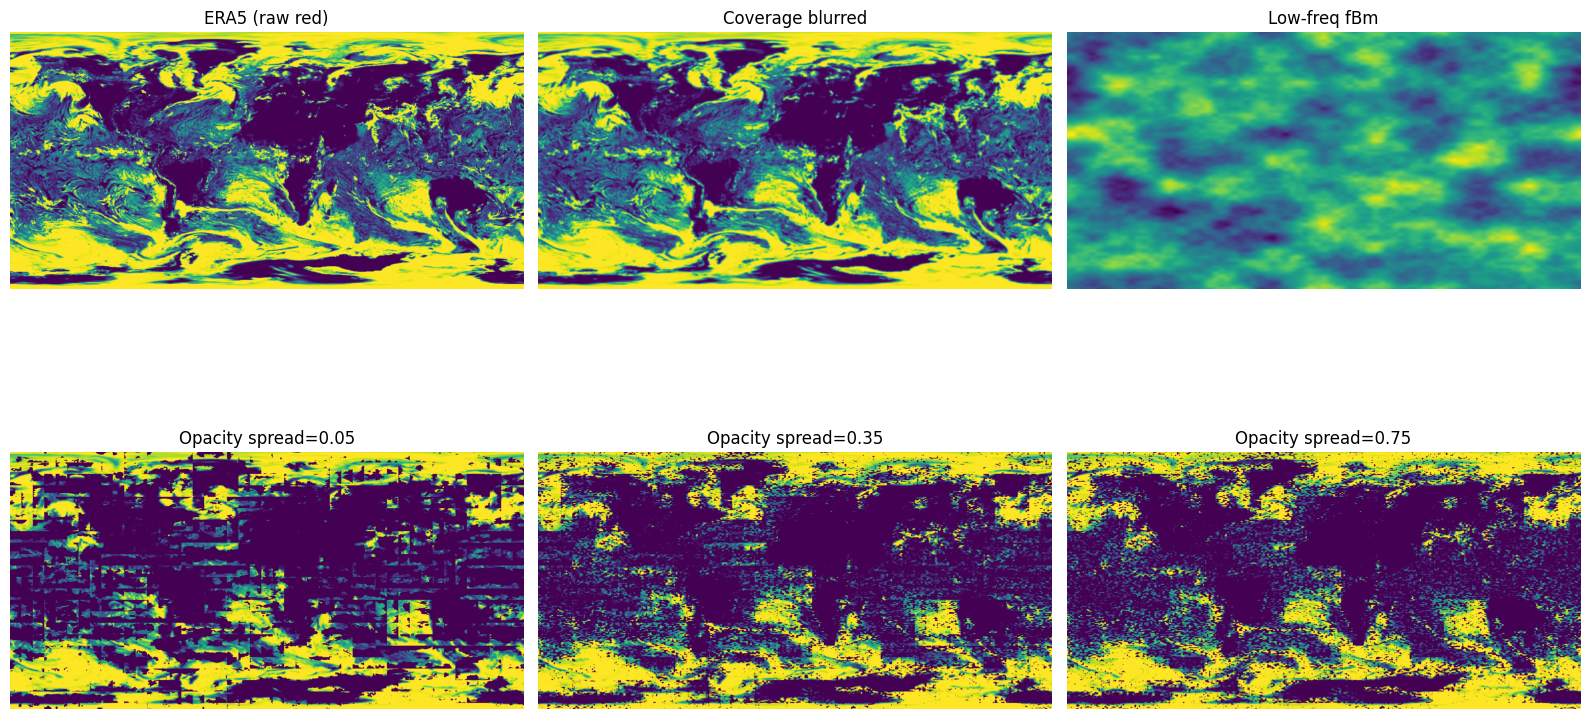

FileNotFoundError: The directory '/mnt/data' does not exist

In [32]:
# Re-run the alternative allocation demo (stateful cell)
import numpy as np, imageio.v2 as imageio
from PIL import Image
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import os, math

def smoothstep(t):
    return t * t * (3.0 - 2.0 * t)

def value_noise_2d(width, height, grid, seed=None):
    rng = np.random.default_rng(seed)
    lattice = rng.random((grid + 1, grid + 1))
    xs = np.linspace(0.0, grid, width, endpoint=False)
    ys = np.linspace(0.0, grid, height, endpoint=False)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    x0 = np.floor(X).astype(int); y0 = np.floor(Y).astype(int)
    x1 = (x0 + 1) % grid;        y1 = (y0 + 1) % grid
    fx = X - x0; fy = Y - y0
    sx = smoothstep(fx); sy = smoothstep(fy)
    v00 = lattice[y0, x0]; v10 = lattice[y0, x1]
    v01 = lattice[y1, x0]; v11 = lattice[y1, x1]
    nx0 = v00 * (1 - sx) + v10 * sx
    nx1 = v01 * (1 - sx) + v11 * sx
    return nx0 * (1 - sy) + nx1 * sy  # [0,1]

def fbm_value(width, height, octaves=4, base_freq=12, persistence=0.5, seed=2025):
    rng = np.random.default_rng(seed)
    result = np.zeros((height, width), dtype=np.float32)
    amp_sum = 0.0; amp = 1.0; freq = base_freq
    for _ in range(octaves):
        result += amp * value_noise_2d(width, height, freq, seed=rng.integers(1<<30))
        amp_sum += amp; amp *= persistence; freq = int(freq * 2)
    result /= max(amp_sum, 1e-6)
    mn, mx = float(result.min()), float(result.max())
    if mx > mn: result = (result - mn) / (mx - mn)
    else: result[:] = 0.5
    return result

# load ERA5
inp_path = "/content/red_only.png"
img = Image.open(inp_path).convert("RGB")
arr = np.asarray(img).astype(np.float32) / 255.0
C_raw = arr[...,0]
C = gaussian_filter(C_raw, sigma=1.2)
C = np.clip(C, 0.0, 1.0)
H, W = C.shape

L_low = fbm_value(W, H, octaves=4, base_freq=10, persistence=0.5, seed=2025)
H_high = value_noise_2d(W, H, grid=256, seed=4242)

def allocate_mask_per_tile(C, spread=0.3, tile_px=32):
    H, W = C.shape
    tiles_y = math.ceil(H / tile_px)
    tiles_x = math.ceil(W / tile_px)
    S = (1.0 - spread) * L_low + spread * H_high
    smin, smax = float(S.min()), float(S.max())
    S = (S - smin) / max(1e-6, (smax - smin))
    M = np.zeros_like(C, dtype=np.uint8)
    for ty in range(tiles_y):
        for tx in range(tiles_x):
            y0, x0 = ty*tile_px, tx*tile_px
            y1, x1 = min(H, y0+tile_px), min(W, x0+tile_px)
            c_blk = C[y0:y1, x0:x1]
            s_blk = S[y0:y1, x0:x1]
            target = int(np.clip(np.rint(c_blk.sum()), 0, c_blk.size))
            if target <= 0:
                continue
            if target >= c_blk.size:
                M[y0:y1, x0:x1] = 1
                continue
            flat = s_blk.ravel()
            idx = np.argpartition(flat, -target)[-target:]
            m_blk = np.zeros_like(flat, dtype=np.uint8)
            m_blk[idx] = 1
            M[y0:y1, x0:x1] = m_blk.reshape(c_blk.shape)
    return M.astype(np.float32)

spreads = [0.05, 0.35, 0.75]
results = []
for sp in spreads:
    M = allocate_mask_per_tile(C, spread=sp, tile_px=32)
    Opacity = M * C
    results.append((sp, M, Opacity))

plt.figure(figsize=(16, 10))
plt.subplot(2,3,1); plt.imshow(C_raw, vmin=0, vmax=1); plt.title("ERA5 (raw red)"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(C, vmin=0, vmax=1); plt.title("Coverage blurred"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(L_low, vmin=0, vmax=1); plt.title("Low‑freq fBm"); plt.axis("off")
for i,(sp,M,Op) in enumerate(results, start=1):
    plt.subplot(2,3,3+i); plt.imshow(Op, vmin=0, vmax=1); plt.title(f"Opacity spread={sp}"); plt.axis("off")
plt.tight_layout(); plt.show()

out_dir = "/mnt/data"
saved = []
for sp, M, Op in results:
    imageio.imwrite(os.path.join(out_dir, f"mask_spread_{sp:.2f}.png"), (M*255).astype(np.uint8))
    fn = os.path.join(out_dir, f"opacity_spread_{sp:.2f}.png")
    imageio.imwrite(fn, (np.clip(Op,0,1)*255).astype(np.uint8))
    saved.append(fn)

saved


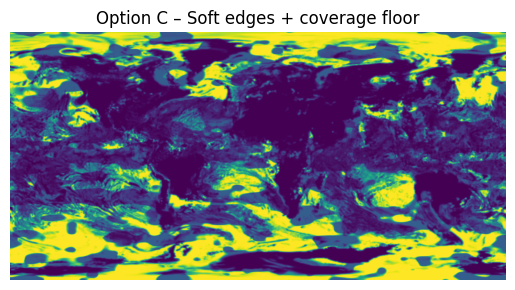

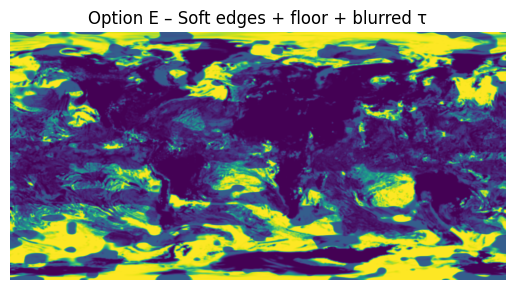

Wrote: opacity_spread_optC.png opacity_spread_optE.png
Wrote: opacity_spread_optC.png opacity_spread_optE.png


In [38]:
# --- Add this cell after C (coverage) exists, before Options C/E ----------------
import numpy as np
from scipy.ndimage import gaussian_filter

def _normalize01(x):
    mn, mx = float(x.min()), float(x.max())
    if mx > mn:
        x = (x - mn) / (mx - mn)
    else:
        x[:] = 0.5
    return np.clip(x, 0.0, 1.0)

def look_with_spread(
    W, H,
    base_freq=12,
    seed=2025,
    # spread knob:
    spread=0.35,
    # low-frequency (clumpy) look params
    clump_octaves=3, clump_persistence=0.55, clump_freq_mult=1.0,
    # high-frequency (wispy) look params
    spread_octaves=2, spread_persistence=0.45, spread_freq_mult=10.0,
    # optional edge bias so fine detail hugs deck boundaries a bit
    edge_bias=0.35,   # 0 = off, 0.3..0.6 = subtle
):
    """
    Returns L_mix in [0,1] controlled by `spread`:
      spread=0 -> clumpy (low-freq)
      spread=1 -> wispy  (high-freq)
    """
    # -- low frequency clumpy fBm
    L_clump = fbm_value(
        W, H,
        octaves=clump_octaves,
        base_freq=max(2, int(base_freq * clump_freq_mult)),
        persistence=clump_persistence,
        seed=seed
    )
    # -- high frequency (wispier) fBm
    L_wisp = fbm_value(
        W, H,
        octaves=spread_octaves,
        base_freq=max(2, int(base_freq * spread_freq_mult)),
        persistence=spread_persistence,
        seed=seed + 1337
    )

    # Optional edge bias so fine speckle hugs edges of clumps instead of breaking decks
    if edge_bias > 0.0:
        gy, gx = np.gradient(L_clump)
        edge = np.hypot(gx, gy)
        edge = _normalize01(edge)**0.8
        L_wisp = (1.0 - edge_bias) * L_wisp + edge_bias * (0.5 + (L_wisp - 0.5) * (0.5 + edge))

    # Mix by spread and normalize
    L_mix = (1.0 - spread) * L_clump + spread * L_wisp
    L_mix = _normalize01(L_mix)
    return L_mix

# -------- Use it to replace your L ----------
# Choose your preferred spread (0..1)
spread = 0  # try 0.1 (clumpy), 0.35 (balanced), 0.7 (wispy)
L = look_with_spread(W, H,
                     spread=spread,
                     clump_octaves=3, clump_persistence=0.55, clump_freq_mult=1.0,
                     spread_octaves=2, spread_persistence=0.45, spread_freq_mult=10.0,
                     edge_bias=0.35)

# ----- keep your existing τ solver as-is to get T (per-tile) -----
T = per_tile_threshold(L, C, iters=12)

# ----- Option C: Soft edges + coverage floor (with spread-aware L) -----
eps = 0.02   # edge feather width in look-space
k   = 0.7    # coverage floor blend (0=none, 1=full)
MaskC    = np.clip((L - (T - eps)) / (2*eps), 0.0, 1.0)  # smoothstep(T-eps, T+eps, L)
OpacityC = (1 - k) * C + k * (MaskC * C)

# ----- Option E: Soft edges + coverage floor + blurred τ (recommended) -----
tau_sigma = 32 * 0.35  # blur τ over ~⅓ tile to reduce tiny holes
T_blur = gaussian_filter(T, sigma=tau_sigma)
MaskE  = np.clip((L - (T_blur - eps)) / (2*eps), 0.0, 1.0)
OpacityE = (1 - k) * C + k * (MaskE * C)

import matplotlib.pyplot as plt
import imageio.v2 as imageio  # if not already imported

# --- show both plots (separate figures) ---
plt.figure()
plt.imshow(np.clip(OpacityC, 0, 1), vmin=0, vmax=1)
plt.title("Option C – Soft edges + coverage floor")
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(np.clip(OpacityE, 0, 1), vmin=0, vmax=1)
plt.title("Option E – Soft edges + floor + blurred τ")
plt.axis('off')
plt.show()

# --- save as before ---
imageio.imwrite("opacity_spread_optC.png", (np.clip(OpacityC, 0, 1)*255).astype(np.uint8))
imageio.imwrite("opacity_spread_optE.png", (np.clip(OpacityE, 0, 1)*255).astype(np.uint8))
print("Wrote:", "opacity_spread_optC.png", "opacity_spread_optE.png")

# Save or show
imageio.imwrite("opacity_spread_optC.png", (np.clip(OpacityC, 0, 1)*255).astype(np.uint8))
imageio.imwrite("opacity_spread_optE.png", (np.clip(OpacityE, 0, 1)*255).astype(np.uint8))

print("Wrote:",
      "opacity_spread_optC.png",
      "opacity_spread_optE.png")


In [ ]:
import numpy as np

# Assuming 'img' is the PIL Image object from the previous cell
if 'img' in locals():
    img_np = np.array(img)
    print("Image converted to NumPy array with shape:", img_np.shape)
else:
    print("Error: Image object 'img' not found. Please run the previous cell first.")

Image converted to NumPy array with shape: (721, 1440, 4)
